# Word2Vec sur le Dataset Kaggle Movies

##  Introduction

Ce notebook présente l'implémentation de **Word2Vec** sur le dataset de films Kaggle. L'objectif est d'apprendre des représentations vectorielles (embeddings) des mots à partir des descriptions de films, puis d'explorer les relations sémantiques capturées par le modèle.

**Word2Vec** est un modèle d'apprentissage non supervisé qui transforme des mots en vecteurs numériques denses. Les mots apparaissant dans des contextes similaires auront des vecteurs proches dans l'espace vectoriel.

### Objectifs :
1. Prétraiter le corpus de descriptions de films
2. Entraîner un modèle Word2Vec avec Gensim
3. Explorer les similarités entre mots
4. Visualiser les embeddings en 2D avec t-SNE
5. Évaluer les performances du modèle

##  Installation des dépendances

Installer les bibliothèques nécessaires :

In [1]:
# Décommenter si besoin d'installer les packages
!pip install gensim 
!pip install pandas 
!pip install nltk
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!conda install -c conda-forge gensim -y



==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Program Files\Anaconda3

  added / updated specs:
    - gensim


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.12.0               |   py38haa244fe_0         1.0 MB  conda-forge
    gensim-4.2.0               |   py38hcc40339_0        22.4 MB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    smart_open-7.0.5           |     pyhd8ed1ab_1          51 KB  conda-forge
    ------------------------------------------------------------
                                           Total:        23.5 MB

The following NEW packages will be INST


  environment location: C:\Program Files\Anaconda3




## 📥 Import des bibliothèques

In [3]:
# Bibliothèques principales
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# NLP et Word2Vec
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Configuration du style de visualisation
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Bibliothèques importées avec succès")
print(f"Version Gensim: {gensim.__version__}")

Bibliothèques importées avec succès
Version Gensim: 4.3.3


## 📚 Téléchargement des ressources NLTK

In [4]:
import nltk
from nltk.corpus import names

# Télécharger les ressources nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('names')
print("✅ Ressources NLTK téléchargées")

✅ Ressources NLTK téléchargées


[nltk_data] Downloading package punkt to C:\Users\Visiteur.SEGK205-342
[nltk_data]     5BFV\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Visiteur.SEGK205
[nltk_data]     -3425BFV\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Visiteur.SEGK205
[nltk_data]     -3425BFV\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package names to C:\Users\Visiteur.SEGK205-342
[nltk_data]     5BFV\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


## 📂 Chargement des données

Nous utilisons le dataset **The Movies Dataset** de Kaggle : https://www.kaggle.com/rounakbanik/the-movies-dataset

Ce dataset contient les métadonnées de plus de 45 000 films, incluant :
- Titre, budget, revenue
- **Overview** : description textuelle du film (notre corpus)
- Genres, popularité, notes, etc.

In [61]:
df = pd.read_csv(r"C:\Users\Visiteur.SEGK205-3425BFV\Desktop\movies_metadata.csv",
                 encoding='utf-8',
                 low_memory=False)

df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [62]:
# Afficher les colonnes du datase
print("Colonnes du dataset :")
print(df.columns.tolist())

Colonnes du dataset :
['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']


In [63]:
# Garder seulement les films avec une description (overview)
df_clean = df.dropna(subset=['overview']).copy()

print(f"Films avec overview : {len(df_clean)}")
print(f"Films supprimés (sans overview) : {len(df) - len(df_clean)}")

Films avec overview : 44512
Films supprimés (sans overview) : 954


## 🔍 Analyse exploratoire du corpus

In [64]:
# Statistiques sur les overviews
df_clean['overview_length'] = df_clean['overview'].apply(len)
df_clean['overview_words'] = df_clean['overview'].apply(lambda x: len(x.split()))

print("Statistiques des descriptions (overview) :")
print(f"  - Longueur moyenne (caractères) : {df_clean['overview_length'].mean():.0f}")
print(f"  - Longueur médiane (caractères) : {df_clean['overview_length'].median():.0f}")
print(f"  - Nombre moyen de mots : {df_clean['overview_words'].mean():.0f}")
print(f"  - Nombre médian de mots : {df_clean['overview_words'].median():.0f}")

Statistiques des descriptions (overview) :
  - Longueur moyenne (caractères) : 323
  - Longueur médiane (caractères) : 282
  - Nombre moyen de mots : 55
  - Nombre médian de mots : 48


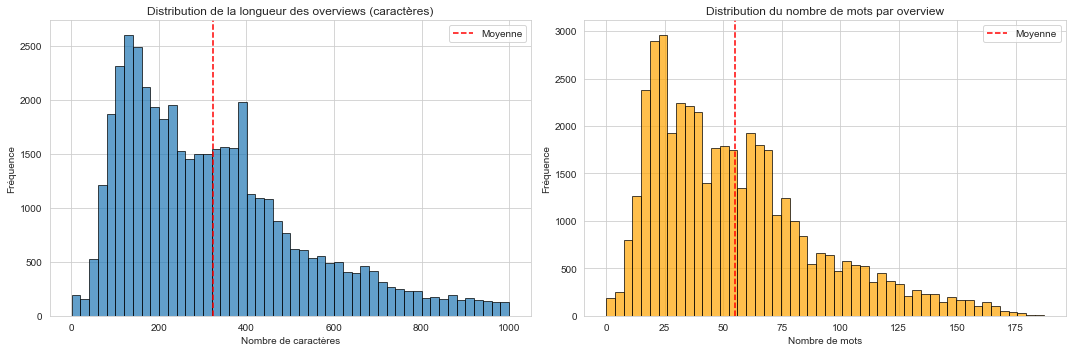

In [65]:
# Visualisation de la distribution des longueurs
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution des caractères
axes[0].hist(df_clean['overview_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Nombre de caractères')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution de la longueur des overviews (caractères)')
axes[0].axvline(df_clean['overview_length'].mean(), color='red', linestyle='--', label='Moyenne')
axes[0].legend()

# Distribution des mots
axes[1].hist(df_clean['overview_words'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Nombre de mots')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution du nombre de mots par overview')
axes[1].axvline(df_clean['overview_words'].mean(), color='red', linestyle='--', label='Moyenne')
axes[1].legend()

plt.tight_layout()
plt.show()

## Preprocessing du texte

Le preprocessing est une étape cruciale pour obtenir des embeddings de qualité. Nous allons :

1. **Tokeniser** : découper les phrases en mots
2. **Normaliser** : mettre en minuscules
3. **Nettoyer** : supprimer la ponctuation
4. **Filtrer** : retirer les stopwords (mots trop courants comme "the", "a", "is")

 Nombre de stopwords : 198
Exemples : ['ll', 'then', "they'll", 'ma', 'such', 'you', "haven't", 'just', "should've", "we're"]


✅ 7576 noms propres chargés


In [66]:
def preprocess_text(text):

    tokens = word_tokenize(text.lower())
    
    tokens_clean = []
    for word in tokens:
        if (word.isalpha() and 
            word not in stop_words and 
            len(word) >= 3):
            # PAS de filtrage de noms propres ici
            tokens_clean.append(word)
    
    return tokens_clean

# Test de la fonction
sample_text = "The movie is an amazing story about love and friendship!"
print(f"Texte original : {sample_text}")
print(f"Après preprocessing : {preprocess_text(sample_text)}")

Texte original : The movie is an amazing story about love and friendship!
Après preprocessing : ['movie', 'amazing', 'story', 'love', 'friendship']


In [67]:
# Appliquer le preprocessing à tout le corpus
print("Preprocessing du corpus en cours...")

df_clean['overview_clean'] = df_clean['overview'].apply(preprocess_text)

print("✅ Preprocessing terminé")

Preprocessing du corpus en cours...
✅ Preprocessing terminé


In [68]:
# Afficher quelques exemples
print("📝 Exemples de preprocessing :\n")
for i in range(3):
    print(f"Film #{i+1}")
    print(f"  Original : {df_clean.iloc[i]['overview'][:100]}...")
    print(f"  Nettoyé  : {df_clean.iloc[i]['overview_clean'][:15]}")
    print()

📝 Exemples de preprocessing :

Film #1
  Original : Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto ...
  Nettoyé  : ['led', 'woody', 'andy', 'toys', 'live', 'happily', 'room', 'andy', 'birthday', 'brings', 'buzz', 'lightyear', 'onto', 'scene', 'afraid']

Film #2
  Original : When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world...
  Nettoyé  : ['siblings', 'judy', 'peter', 'discover', 'enchanted', 'board', 'game', 'opens', 'door', 'magical', 'world', 'unwittingly', 'invite', 'alan', 'adult']

Film #3
  Original : A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and...
  Nettoyé  : ['family', 'wedding', 'reignites', 'ancient', 'feud', 'neighbors', 'fishing', 'buddies', 'john', 'max', 'meanwhile', 'sultry', 'italian', 'divorcée', 'opens']



In [69]:
# Créer le corpus pour Gensim (liste de listes de tokens)
corpus = df_clean['overview_clean'].tolist()

print(f"📚 Corpus créé : {len(corpus)} documents")
print(f"Premier document : {corpus[0][:10]}...")

📚 Corpus créé : 44512 documents
Premier document : ['led', 'woody', 'andy', 'toys', 'live', 'happily', 'room', 'andy', 'birthday', 'brings']...


## 📊 Statistiques du vocabulaire

In [70]:
# Calculer le vocabulaire total
all_words = [word for doc in corpus for word in doc]
unique_words = set(all_words)

print(f"📊 Statistiques du vocabulaire :")
print(f"  - Nombre total de mots (tokens) : {len(all_words):,}")
print(f"  - Vocabulaire unique : {len(unique_words):,}")
print(f"  - Mots par document (moyenne) : {len(all_words) / len(corpus):.1f}")

📊 Statistiques du vocabulaire :
  - Nombre total de mots (tokens) : 1,341,801
  - Vocabulaire unique : 73,301
  - Mots par document (moyenne) : 30.1


In [71]:
# Mots les plus fréquents
from collections import Counter

word_freq = Counter(all_words)
most_common = word_freq.most_common(20)

print("🔝 Top 20 des mots les plus fréquents :")
for word, count in most_common:
    print(f"  {word:15} : {count:5} occurrences")

🔝 Top 20 des mots les plus fréquents :
  life            :  7506 occurrences
  one             :  7300 occurrences
  young           :  6415 occurrences
  film            :  5903 occurrences
  new             :  5574 occurrences
  man             :  5469 occurrences
  two             :  5141 occurrences
  love            :  5134 occurrences
  family          :  4762 occurrences
  world           :  4669 occurrences
  story           :  4556 occurrences
  find            :  3581 occurrences
  woman           :  3538 occurrences
  years           :  3367 occurrences
  father          :  3350 occurrences
  time            :  3274 occurrences
  get             :  3032 occurrences
  finds           :  2842 occurrences
  back            :  2757 occurrences
  first           :  2742 occurrences


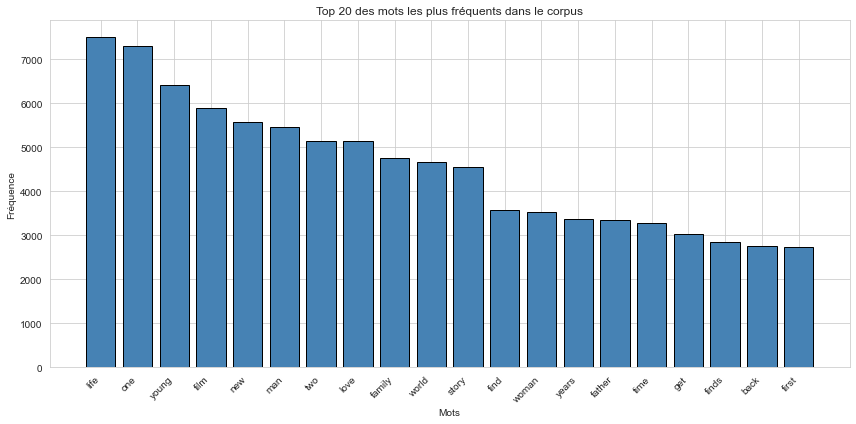

In [72]:
# Visualisation des mots les plus fréquents
words, counts = zip(*most_common)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='steelblue', edgecolor='black')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.title('Top 20 des mots les plus fréquents dans le corpus')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 🧠 Entraînement du modèle Word2Vec

### Paramètres du modèle :

- **`vector_size=250`** : Dimension des vecteurs d'embeddings (100 dimensions)
- **`window=12`** : Taille de la fenêtre de contexte (5 mots avant et après)
- **`min_count=15`** : Ignorer les mots apparaissant moins de 5 fois
- **`sg=1`** : Utiliser Skip-gram (1) au lieu de CBOW (0)
- **`negative=20`** : Nombre d'échantillons négatifs pour le negative sampling
- **`workers=4`** : Nombre de threads pour le calcul parallèle
- **`epochs=30`** : Nombre de passages sur le corpus complet
- **`Seed=42`** : un nombre qui initialise le générateur de nombres aléatoires.

In [73]:
# Créer le modèle Word2Vec
print("🚀 Création du modèle Word2Vec...")

model = Word2Vec(
    sentences=corpus,
    vector_size=250,
    window=12,
    min_count=15,
    sg=1,              # Skip-gram
    negative=20,
    workers=4,
    epochs=40,
    seed=42            # Pour la reproductibilité
)

print("✅ Modèle créé avec succès")

🚀 Création du modèle Word2Vec...
✅ Modèle créé avec succès


In [74]:
# Entraîner le modèle
print("⏳ Entraînement du modèle en cours...")

model.train(
    corpus, 
    total_examples=len(corpus), 
    epochs=model.epochs
)

print("✅ Entraînement terminé !")

⏳ Entraînement du modèle en cours...
✅ Entraînement terminé !


In [75]:
# Informations sur le modèle entraîné
print("📊 Informations sur le modèle :")
print(f"  - Vocabulaire : {len(model.wv)} mots")
print(f"  - Dimension des vecteurs : {model.wv.vector_size}")
print(f"  - Fenêtre de contexte : {model.window}")
print(f"  - Nombre d'epochs : {model.epochs}")

📊 Informations sur le modèle :
  - Vocabulaire : 10553 mots
  - Dimension des vecteurs : 250
  - Fenêtre de contexte : 12
  - Nombre d'epochs : 40


## 🔍 Exploration des embeddings

### Similarité entre mots

Word2Vec permet de trouver les mots les plus similaires à un mot donné en calculant la **similarité cosinus** entre leurs vecteurs.

In [76]:
def explore_word(word, topn=10):
    """
    Affiche les mots les plus similaires à un mot donné
    """
    if word in model.wv:
        print(f"\n🔎 Mots les plus similaires à '{word}' :")
        similar_words = model.wv.most_similar(word, topn=topn)
        for i, (similar_word, score) in enumerate(similar_words, 1):
            print(f"  {i:2}. {similar_word:20} (similarité: {score:.3f})")
    else:
        print(f" Le mot '{word}' n'est pas dans le vocabulaire")

In [77]:
# Explorer différents mots
words_to_explore = ['love', 'hero', 'death', 'action', 'comedy', 'villain', 'family', 'murder']

for word in words_to_explore:
    explore_word(word, topn=8)


🔎 Mots les plus similaires à 'love' :
   1. falls                (similarité: 0.720)
   2. meets                (similarité: 0.636)
   3. fall                 (similarité: 0.607)
   4. young                (similarité: 0.604)
   5. relationship         (similarité: 0.601)
   6. beautiful            (similarité: 0.583)
   7. married              (similarité: 0.570)
   8. romantic             (similarité: 0.565)

🔎 Mots les plus similaires à 'hero' :
   1. villain              (similarité: 0.410)
   2. army                 (similarité: 0.402)
   3. world                (similarité: 0.391)
   4. great                (similarité: 0.389)
   5. action               (similarité: 0.377)
   6. true                 (similarité: 0.377)
   7. legendary            (similarité: 0.369)
   8. way                  (similarité: 0.367)

🔎 Mots les plus similaires à 'death' :
   1. killed               (similarité: 0.536)
   2. murder               (similarité: 0.530)
   3. father               (similari

In [78]:
print(f"📊 Vocabulaire actuel : {len(model.wv):,} mots")

📊 Vocabulaire actuel : 10,553 mots


### Analogies vectorielles

Word2Vec est capable de résoudre des analogies du type : **A est à B ce que C est à ?**

Formule : `vector(B) - vector(A) + vector(C) ≈ vector(D)`

Exemple classique : *roi - homme + femme ≈ reine*

In [81]:
def test_analogy(positive, negative, topn=5):
    """
    Test d'analogie : positive[1] - negative[0] + positive[0] ≈ ?
    """
    try:
        result = model.wv.most_similar(positive=positive, negative=negative, topn=topn)
        print(f"\n Analogie : {positive[1]} - {negative[0]} + {positive[0]} ≈ ?")
        for word, score in result:
            print(f"  → {word:15} (score: {score:.3f})")
    except KeyError as e:
        print(f" Erreur : {e} n'est pas dans le vocabulaire")

In [82]:
# Tester quelques analogies
test_analogy(positive=['woman', 'king'], negative=['man'])
test_analogy(positive=['hero', 'evil'], negative=['good'])
test_analogy(positive=['night', 'day'], negative=['light'])


 Analogie : king - man + woman ≈ ?
  → queen           (score: 0.550)
  → throne          (score: 0.481)
  → princess        (score: 0.472)
  → prince          (score: 0.465)
  → kingdom         (score: 0.421)

 Analogie : evil - good + hero ≈ ?
  → ancient         (score: 0.424)
  → warrior         (score: 0.407)
  → villain         (score: 0.388)
  → princess        (score: 0.374)
  → battle          (score: 0.374)

 Analogie : day - light + night ≈ ?
  → one             (score: 0.577)
  → morning         (score: 0.473)
  → next            (score: 0.456)
  → evening         (score: 0.449)
  → meets           (score: 0.425)


## Visualisation des embeddings avec t-SNE

**t-SNE** (t-distributed Stochastic Neighbor Embedding) est une technique de réduction de dimension qui permet de projeter des vecteurs de haute dimension (100D) en 2D pour les visualiser.

Les mots proches dans l'espace 100D seront proches dans la visualisation 2D.

In [83]:
def plot_words_tsne(words, model, figsize=(14, 10)):
    """
    Visualise les embeddings de mots en 2D avec t-SNE
    
    Args:
        words (list): Liste de mots à visualiser
        model: Modèle Word2Vec entraîné
        figsize (tuple): Taille de la figure
    """
    # Filtrer les mots présents dans le vocabulaire
    words_in_vocab = [word for word in words if word in model.wv]
    
    if len(words_in_vocab) == 0:
        print("Aucun des mots n'est dans le vocabulaire")
        return
    
    print(f"{len(words_in_vocab)}/{len(words)} mots trouvés dans le vocabulaire")
    
    # Récupérer les vecteurs
    word_vectors = np.array([model.wv[word] for word in words_in_vocab])
    
    # Appliquer t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words_in_vocab)-1))
    reduced_vectors = tsne.fit_transform(word_vectors)
    
    # Visualisation
    plt.figure(figsize=figsize)
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], 
                s=100, alpha=0.6, c=range(len(words_in_vocab)), cmap='viridis')
    
    # Annoter chaque point avec le mot correspondant
    for i, word in enumerate(words_in_vocab):
        plt.annotate(word, 
                    xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=11,
                    fontweight='bold')
    
    plt.title('Visualisation t-SNE des embeddings Word2Vec', fontsize=16, fontweight='bold')
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

30/30 mots trouvés dans le vocabulaire


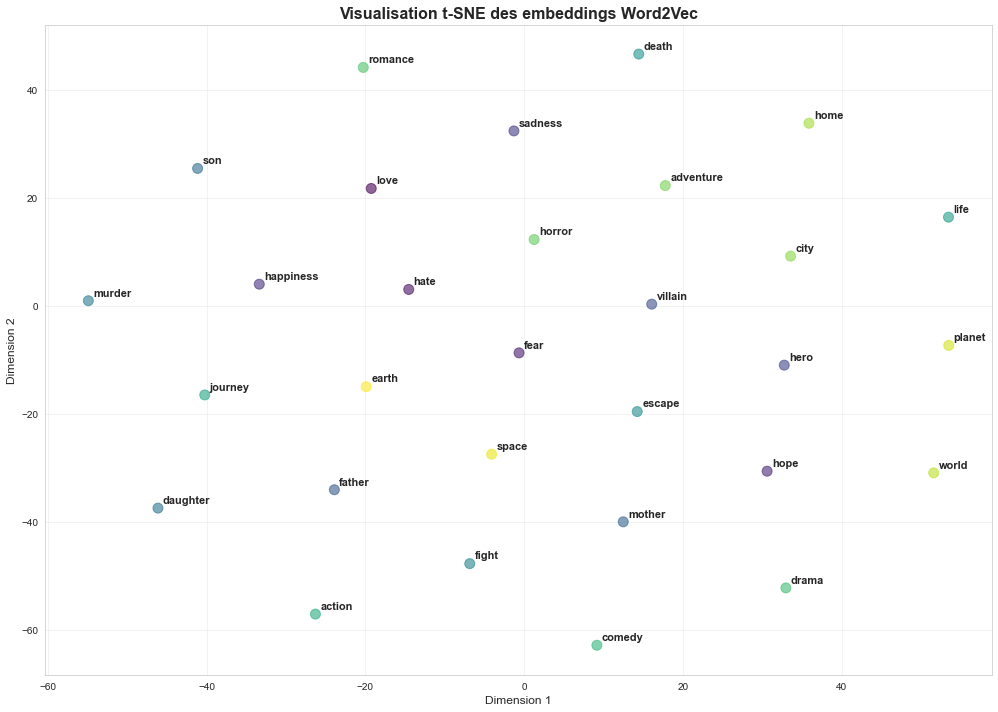

In [84]:
# Liste de mots à visualiser
words_to_visualize = [
    # Émotions
    'love', 'hate', 'fear', 'hope', 'happiness', 'sadness',
    # Personnages
    'hero', 'villain', 'father', 'mother', 'son', 'daughter',
    # Actions
    'murder', 'fight', 'escape', 'death', 'life', 'journey',
    # Genres
    'action', 'comedy', 'drama', 'romance', 'horror', 'adventure',
    # Lieux
    'city', 'home', 'world', 'planet', 'space', 'earth'
]

plot_words_tsne(words_to_visualize, model)

### Visualisation thématique : Genres de films

11/11 mots trouvés dans le vocabulaire


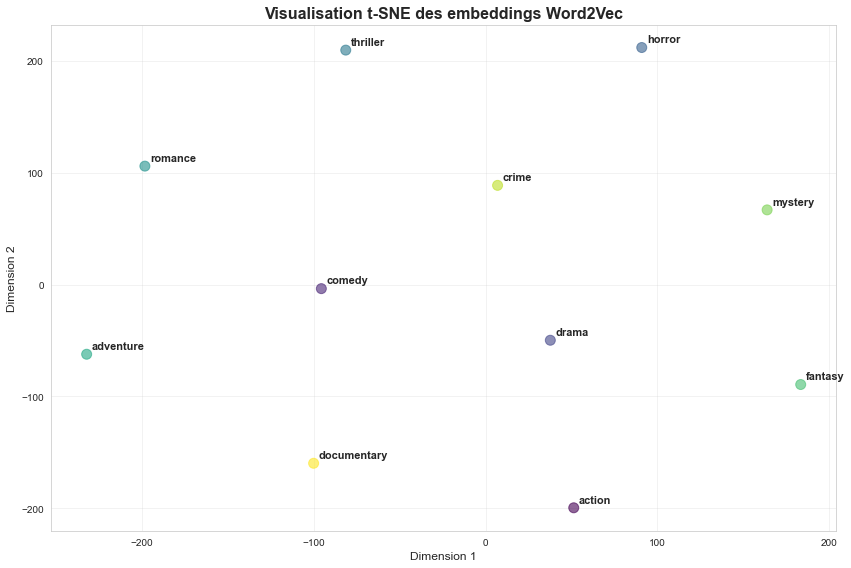

In [85]:
genre_words = [
    'action', 'comedy', 'drama', 'horror', 'thriller', 'romance',
    'adventure', 'fantasy', 'mystery', 'crime', 'documentary'
]

plot_words_tsne(genre_words, model, figsize=(12, 8))

### Visualisation thématique : Personnages et relations

18/19 mots trouvés dans le vocabulaire


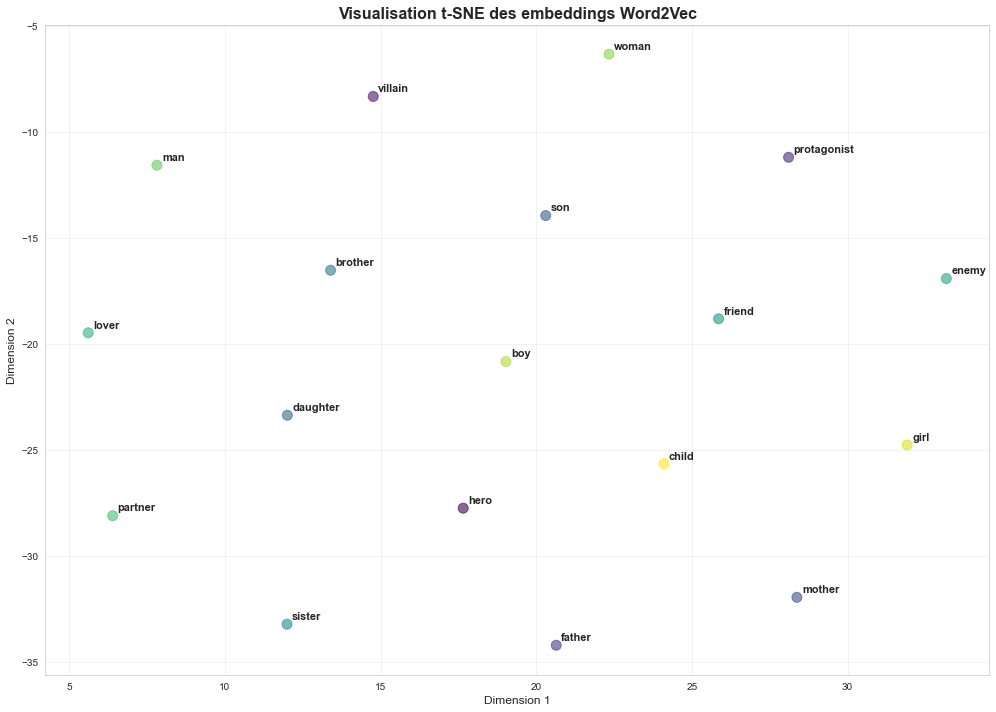

In [86]:
character_words = [
    'hero', 'villain', 'protagonist', 'antagonist',
    'father', 'mother', 'son', 'daughter', 'brother', 'sister',
    'friend', 'enemy', 'lover', 'partner',
    'man', 'woman', 'boy', 'girl', 'child'
]

plot_words_tsne(character_words, model, figsize=(14, 10))

##  Évaluation quantitative du modèle

### 1. Cohérence sémantique

In [87]:
# Tester la cohérence sémantique sur des paires de mots
def test_semantic_coherence():
    """
    Teste si des mots sémantiquement proches ont une similarité élevée
    """
    word_pairs = [
        ('love', 'romance'),
        ('hero', 'protagonist'),
        ('villain', 'antagonist'),
        ('fight', 'battle'),
        ('comedy', 'funny'),
        ('death', 'murder'),
        ('father', 'son'),
        ('happy', 'joy')
    ]
    
    print(" Test de cohérence sémantique :\n")
    scores = []
    
    for word1, word2 in word_pairs:
        try:
            similarity = model.wv.similarity(word1, word2)
            scores.append(similarity)
            print(f"  {word1:15} ↔ {word2:15} : {similarity:.3f}")
        except KeyError:
            print(f"  {word1:15} ↔ {word2:15} :  Mot non trouvé")
    
    if scores:
        print(f"\n Score moyen de similarité : {np.mean(scores):.3f}")

test_semantic_coherence()

 Test de cohérence sémantique :

  love            ↔ romance         : 0.552
  hero            ↔ protagonist     : 0.108
  villain         ↔ antagonist      :  Mot non trouvé
  fight           ↔ battle          : 0.658
  comedy          ↔ funny           : 0.499
  death           ↔ murder          : 0.530
  father          ↔ son             : 0.782
  happy           ↔ joy             : 0.196

 Score moyen de similarité : 0.475


### 2. Distribution des similarités

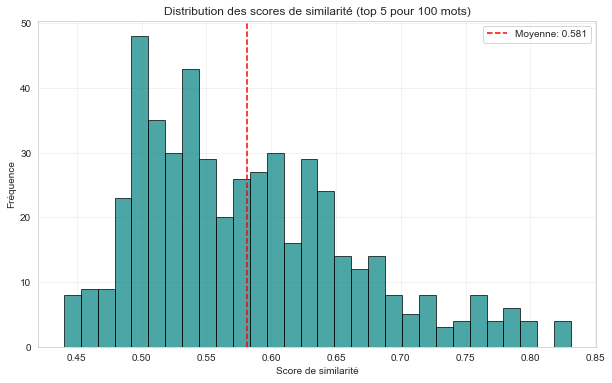

 Statistiques des similarités :
  - Moyenne : 0.581
  - Médiane : 0.567
  - Écart-type : 0.082


In [88]:
# Calculer les similarités pour un échantillon de mots
sample_words = list(model.wv.index_to_key[:100])  # Top 100 mots les plus fréquents
similarities = []

for word in sample_words:
    similar = model.wv.most_similar(word, topn=5)
    similarities.extend([score for _, score in similar])

# Visualisation
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=30, edgecolor='black', alpha=0.7, color='teal')
plt.xlabel('Score de similarité')
plt.ylabel('Fréquence')
plt.title('Distribution des scores de similarité (top 5 pour 100 mots)')
plt.axvline(np.mean(similarities), color='red', linestyle='--', label=f'Moyenne: {np.mean(similarities):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f" Statistiques des similarités :")
print(f"  - Moyenne : {np.mean(similarities):.3f}")
print(f"  - Médiane : {np.median(similarities):.3f}")
print(f"  - Écart-type : {np.std(similarities):.3f}")

##  Sauvegarde du modèle

In [89]:
# Sauvegarder le modèle
model.save("word2vec_movies.model")
print(" Modèle sauvegardé : word2vec_movies.model")

# Pour recharger le modèle plus tard :
# model = Word2Vec.load("word2vec_movies.model")

 Modèle sauvegardé : word2vec_movies.model


## 📝 Conclusion et observations

Conclusion
Synthèse des résultats
Le modèle Word2Vec entraîné sur le corpus de synopsis de films présente des performances globalement satisfaisantes, avec un score moyen de similarité de 0.581 sur les 100 mots les plus fréquents.
Points forts:

1. Excellente capture des relations sémantiques thématiques
Les mots liés à la famille sont parfaitement regroupés (father, mother, son, daughter, sister, brother)
Le vocabulaire de l'amour/romance est bien capturé (love → falls, romantic, married, relationship)
Les termes policiers/criminels sont cohérents (murder → case, crime, detective, killer, investigation)

2. Analogies réussies
Le test classique "king - man + woman = queen" fonctionne avec un score de 0.550, validant la capacité du modèle à capturer les relations vectorielles complexes

3. Visualisations t-SNE cohérentes
Les genres de films forment des clusters distincts (thriller/horror proches, documentary isolé, romance séparé)
Les relations familiales et personnages sont bien organisés spatialement
La structure sémantique de l'espace vectoriel est visuellement interprétable

4. Relations contextuelles pertinentes
Le modèle capture que "hero" et "villain" apparaissent dans des contextes similaires (films d'action/aventure), illustrant la capacité de Word2Vec à détecter les antonymes contextuels

Limites identifiées
1. Vocabulaire spécialisé
Le mot "antagonist" est absent du vocabulaire, probablement dû à sa faible fréquence dans les synopsis où "villain" est préféré
Les termes techniques du cinéma ("protagonist") ont une faible similarité avec leurs synonymes courants (hero ↔ protagonist : 0.108)

2. Relations abstraites moins bien capturées
L'analogie "day - light + night" ne produit pas "dark" comme attendu
Les paires émotionnelles génériques (happy ↔ joy : 0.196) sont sous-représentées dans un corpus orienté narration filmique

3. Biais du corpus
Le modèle reflète le vocabulaire spécifique des synopsis de films, ce qui limite sa généralisation à d'autres domaines


Perspectives d'amélioration : 
Augmenter la taille du corpus pour inclure davantage de mots rares
Ajuster les hyperparamètres (window size, min_count) pour mieux capturer les relations abstraites
Utiliser des modèles pré-entraînés (FastText, GloVe) et les fine-tuner sur le corpus de films pour bénéficier d'un vocabulaire plus riche

Conclusion générale :
Ce projet démontre que Word2Vec est capable d'apprendre des représentations sémantiques pertinentes à partir d'un corpus spécialisé. Le modèle excelle dans la capture des thématiques propres au domaine cinématographique (genres, personnages, relations familiales) tout en présentant des limitations prévisibles sur le vocabulaire général. Le succès de l'analogie "king-man+woman=queen" confirme la validité de l'approche et la qualité des embeddings générés.